# Imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Data

We will be creating sine wave data to test the prediction of a RNN

## Create data

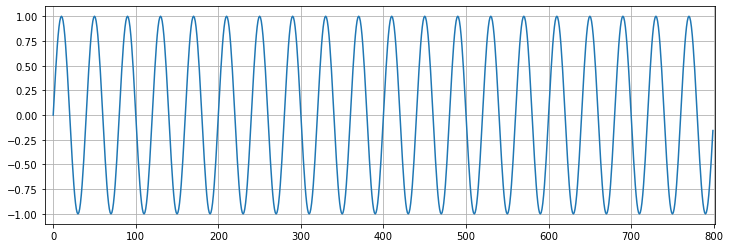

In [2]:
x = torch.linspace(0,799,steps=800)
y = torch.sin(x*2*math.pi/40)

plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(x.numpy(),y.numpy())
plt.xlim(-10,801);

## Train/test split

Given that it is sequencial data, it cannot be randomly selected. We have selected a test size of 40 because the period of a sine wave is found by $\frac{2\pi}{|B|}$. Our sine function is $f(x)=\frac{2\pi x}{40}$ so our period equals $\frac{2\pi}{\frac{2\pi}{40}} = \frac{40\cdot 2\pi}{2\pi} = 40$.

In [3]:
test_size = 40

train_set = y[:-test_size]
test_set = y[-test_size:]

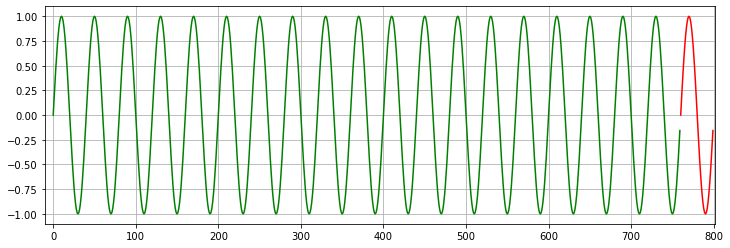

In [4]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(x.numpy()[:-test_size],train_set.numpy(),'g')
plt.plot(x.numpy()[-test_size:],test_set.numpy(),'r')
plt.xlim(-10,801);

## Prepare the training data

We need to create the windows of data that we will train with. These windows will have a sequence and a label that will be predicted. The label would be overlapping with the sequence of the next window.

For example if we have 12 observations and we are feeding size-4 windows we would have $[x_1, x_2, x_3, x_4]$ for the model to predict $x_5$. The following window would include $[x_2, x_3, x_4, x_5]$ to predict $x_6$

In [5]:
def input_data(seq, ws, l=1):
    '''
    Creates the windows of data that willb e used for training.
    '''
    out = []
    for i in range(len(seq)-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+l]
        out.append((window,label))
    return out

In [6]:
# Extract training data
window_size = 40 # One period of our sine wave
train_data = input_data(train_set,window_size)

print(f'Expected = 800 - 40(test) - 40(window) = 720\tActual = {len(train_data)}')

Expected = 800 - 40(test) - 40(window) = 720	Actual = 720


# Define an LSTM model

The model will have an LSTM layer with with a single input and 50 hidden layers. The layers will expand the input to the number of layers, these will then need to be consolidated to output a single output through a fully-connected layer.

During the training, we will be passing three tensors to the LSTM layer:
1. Sequence
2. Hidden state $h_0$
3. Cell state $c_0$

The hidden $h_0$ and cell $c_0$ state tensors have to be initialised. This can be done with random values or zeroes.

When creating the forward pass the LSTM layer will output the LSTM output + hidden and cell states. These will then need to be updated on the forward pass.

The LSTM layer expects an input of size `input, (h_0,c_0)`

In [8]:
class LSTM(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=50,out_size=1):
        
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer
        self.lstm = nn.LSTM(input_size,hidden_size) 
        
        # Add a fully-connected layer
        self.linear = nn.Linear(hidden_size,out_size)
        
        # Initialize h0 and c0
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))
        
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(ltsm_out.view(len(seq),-1))
        return pred[-1]

## Instantiate the model, define loss & optimisation functions

In [9]:
torch.manual_seed(42)
model = LSTM()

criterion = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(),0.01)
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [10]:
# Number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   200
 10000
   200
   200
    50
     1
______
 10651
